In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import functools
import math

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env_to_use = 0

discrete_actions = True

env = gym.make(envs[env_to_use]).unwrapped
if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.001

In [2]:
def train_gan(pop,p_fitness,population_size,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    
    gen_explore_all = []
    gen_exploit_all = []
    dis_loss_all = []
    dis_confidence_all = []
    for e in range(n_epochs):
        #shuffle arrays in unison
        #print(pop.numel())
        #ind = np.arange(population_size)
        #np.random.shuffle(ind)
        #pop = pop[ind]
        #p_fitness = p_fitness[ind]
        for i in range(population_size//batch_size):
            #turn population into vectors
            p_batch = pop[i*batch_size:(i*batch_size)+batch_size].detach()
            f_batch = p_fitness[i*batch_size:(i*batch_size)+batch_size].detach()
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            
            dis_out_r,_ = dis(p_batch)
            dis_out_r = dis_out_r.squeeze(-1)
            
            dis_error_real = (torch.pow((dis_out_r[...,0]-f_batch),2))
            dis_error_real_mean = torch.mean(dis_error_real)
            dis_error_real_mean.backward(retain_graph=True)
            
            #discriminator confidence in its prediction
            dis_confidence = torch.mean(torch.pow(dis_out_r[...,1]-dis_error_real.detach(),2))
            dis_confidence.backward()
            
            dis_optimizer.step() 
            dis_loss_all.append(dis_error_real_mean)  
            dis_confidence_all.append(torch.mean(dis_out_r[...,1]))
            
        #if False:
        for i in range(population_size//batch_size):
            gen_optimizer.zero_grad()
            gen_out = gen(p_batch.detach(),lr)
            dis_out_f,dis_out_latent = dis(p_batch + gen_out)
            
            #define generator loss
            variety = -torch.mean(torch.std(dis_out_latent,-1))
            
            gen_error_exploration = (variety)-torch.mean(dis_out_f[...,1])
            gen_error_exploitation = -torch.mean(dis_out_f[...,0]) 
            gen_error =  gen_error_exploitation + (gen_error_exploration)
            
            gen_error.backward()
            gen_optimizer.step() 
            
            gen_explore_all.append(gen_error_exploration)
            gen_exploit_all.append(gen_error_exploitation)
            
    print(f_batch)
    print(dis_out_r[...,0])   
    
    return gen_explore_all,gen_exploit_all, dis_loss_all,dis_confidence_all

starting training
386
Measured population fitness : 0s
population fitness : [19. 12. 10. 14. 11. 11.  9. 11. 10. 11.]
mean fit : 11.8
tensor([ 2.6540,  0.0737, -0.6635,  0.8109, -0.2949, -0.2949, -1.0321, -0.2949,
        -0.6635, -0.2949], device='cuda:0')
tensor([ 2.6725,  0.1055, -0.6407,  0.8401, -0.2681, -0.2734, -1.0101, -0.2706,
        -0.6319, -0.2678], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


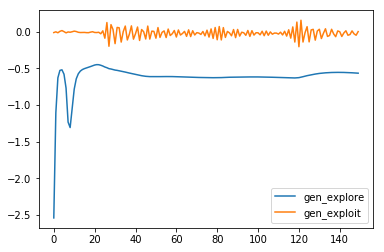

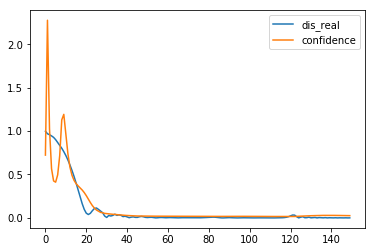

Generation 1  fitness : 19.0
#################################
Measured population fitness : 0s
population fitness : [24. 12.  9. 19. 11. 10. 10. 10.  9.  9.]
mean fit : 12.3
tensor([ 1.7741, -0.0128, -0.5233,  0.4978, -0.2680, -0.2680, -0.7785, -0.2680,
        -0.5233, -0.2680,  3.0503, -0.0128, -0.7785,  1.7741, -0.2680, -0.5233,
        -0.5233, -0.5233, -0.7785, -0.7785], device='cuda:0')
tensor([ 2.4182, -0.0351, -0.6600,  1.1404, -0.2841, -0.3871, -0.6500, -0.4046,
        -0.6702, -0.5509,  2.4182, -0.0351, -0.6600,  1.1404, -0.2841, -0.3871,
        -0.6500, -0.4046, -0.6702, -0.5509],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


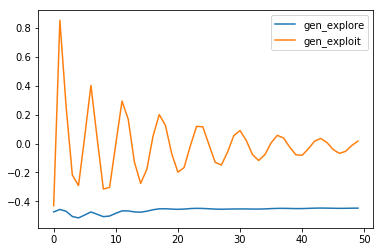

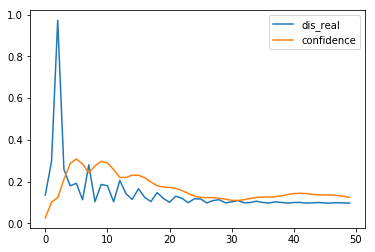

Generation 2  fitness : 24.0
#################################
Measured population fitness : 0s
population fitness : [24.  9. 10. 20. 11.  9. 11. 12. 10. 10.]
mean fit : 12.6
tensor([ 2.7598, -0.0547, -0.7583,  1.5871, -0.2893, -0.5238, -0.5238, -0.5238,
        -0.7583, -0.7583,  2.7598, -0.7583, -0.5238,  1.8216, -0.2893, -0.7583,
        -0.2893, -0.0547, -0.5238, -0.5238], device='cuda:0')
tensor([ 2.8212, -0.3664, -0.6170,  1.7592, -0.2543, -0.5997, -0.3685, -0.2568,
        -0.5954, -0.5832,  2.8212, -0.3664, -0.6170,  1.7592, -0.2543, -0.5997,
        -0.3685, -0.2568, -0.5954, -0.5832],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


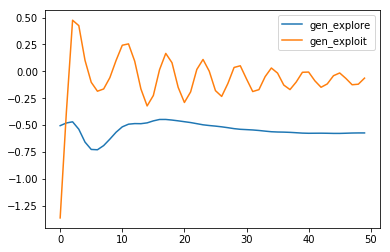

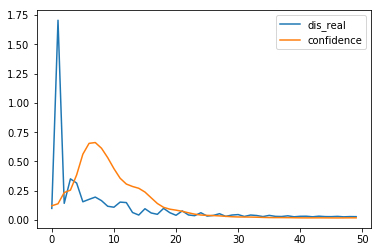

Generation 3  fitness : 24.0
#################################
Measured population fitness : 0s
population fitness : [23. 11. 11. 17.  9. 10. 10. 11.  8.  9.]
mean fit : 11.9
tensor([ 2.7605, -0.7338, -0.5008,  1.8287, -0.2679, -0.7338, -0.2679, -0.0349,
        -0.5008, -0.5008,  2.5275, -0.2679, -0.2679,  1.1298, -0.7338, -0.5008,
        -0.5008, -0.2679, -0.9668, -0.7338], device='cuda:0')
tensor([ 2.6242, -0.5296, -0.3523,  1.4962, -0.5281, -0.6459, -0.3593, -0.1258,
        -0.7407, -0.6448,  2.6242, -0.5296, -0.3523,  1.4962, -0.5281, -0.6459,
        -0.3593, -0.1258, -0.7407, -0.6448],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


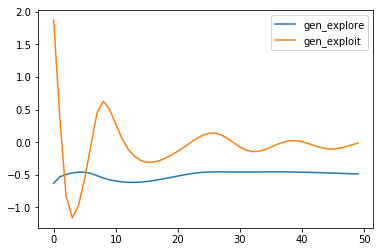

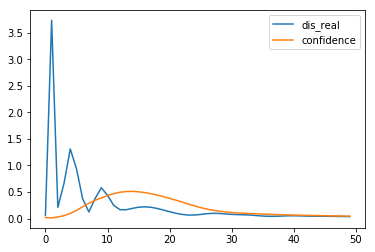

Generation 4  fitness : 23.0
#################################
Measured population fitness : 0s
population fitness : [18.  9. 10. 21. 11. 10. 10. 10.  9. 12.]
mean fit : 12.0
tensor([ 2.5799, -0.2656, -0.2656,  1.1571, -0.7398, -0.5027, -0.5027, -0.2656,
        -0.9769, -0.7398,  1.3943, -0.7398, -0.5027,  2.1056, -0.2656, -0.5027,
        -0.5027, -0.5027, -0.7398, -0.0285], device='cuda:0')
tensor([ 2.0200, -0.4883, -0.3450,  1.6881, -0.4859, -0.4849, -0.4528, -0.3499,
        -0.8306, -0.3657,  2.0200, -0.4883, -0.3450,  1.6881, -0.4859, -0.4849,
        -0.4528, -0.3499, -0.8306, -0.3657],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


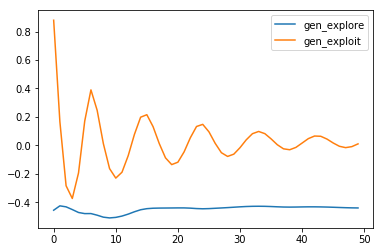

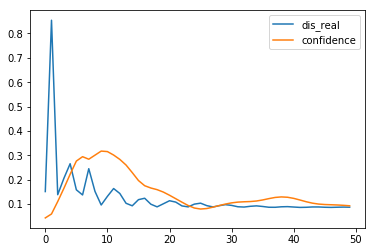

Generation 5  fitness : 21.0
#################################
Measured population fitness : 0s
population fitness : [24. 10.  9. 19.  9. 11.  8. 11.  9. 15.]
mean fit : 12.5
tensor([ 1.3350, -0.7306, -0.5011,  2.0236, -0.2716, -0.5011, -0.5011, -0.5011,
        -0.7306, -0.0421,  2.7121, -0.5011, -0.7306,  1.5645, -0.7306, -0.2716,
        -0.9602, -0.2716, -0.7306,  0.6465], device='cuda:0')
tensor([ 1.9978, -0.6102, -0.6162,  1.7671, -0.4924, -0.3853, -0.7327, -0.3862,
        -0.7319,  0.3028,  1.9978, -0.6102, -0.6162,  1.7671, -0.4924, -0.3853,
        -0.7327, -0.3862, -0.7319,  0.3028],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


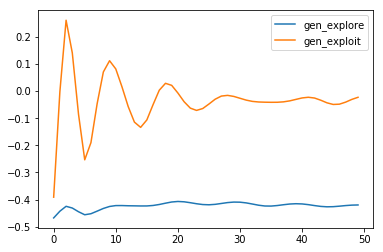

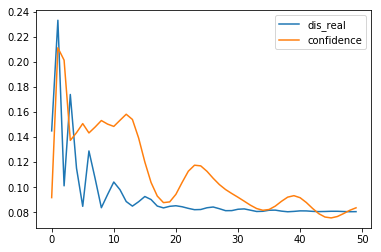

Generation 6  fitness : 24.0
#################################
Measured population fitness : 0s
population fitness : [17. 10. 10. 24. 11. 10. 10. 12. 10.  9.]
mean fit : 12.3
tensor([ 2.6998, -0.5034, -0.7322,  1.5558, -0.7322, -0.2746, -0.9609, -0.2746,
        -0.7322,  0.6406,  1.0982, -0.5034, -0.5034,  2.6998, -0.2746, -0.5034,
        -0.5034, -0.0458, -0.5034, -0.7322], device='cuda:0')
tensor([ 1.9074, -0.4970, -0.6181,  2.1356, -0.4943, -0.3932, -0.7297, -0.1638,
        -0.6035, -0.0387,  1.9074, -0.4970, -0.6181,  2.1356, -0.4943, -0.3932,
        -0.7297, -0.1638, -0.6035, -0.0387],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


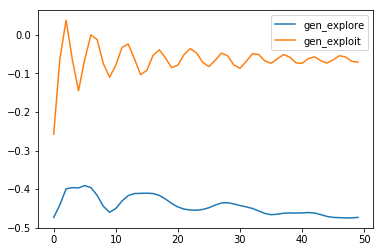

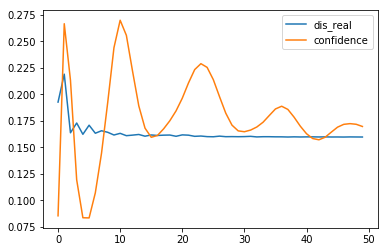

Generation 7  fitness : 24.0
#################################
Measured population fitness : 0s
population fitness : [25. 10. 10. 19. 11. 10.  8.  9. 10.  9.]
mean fit : 12.1
tensor([ 1.0740, -0.4882, -0.4882,  2.6363, -0.2650, -0.4882, -0.4882, -0.0418,
        -0.4882, -0.7114,  2.8594, -0.4882, -0.4882,  1.5204, -0.2650, -0.4882,
        -0.9345, -0.7114, -0.4882, -0.7114], device='cuda:0')
tensor([ 1.9763, -0.4748, -0.4758,  2.0931, -0.2528, -0.4809, -0.7072, -0.3772,
        -0.4719, -0.7167,  1.9763, -0.4748, -0.4758,  2.0931, -0.2528, -0.4809,
        -0.7072, -0.3772, -0.4719, -0.7167],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


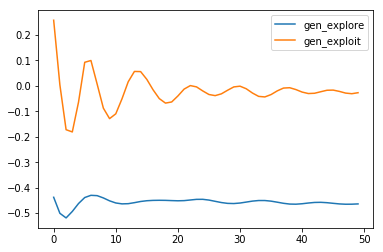

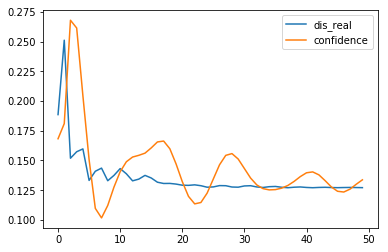

Generation 8  fitness : 25.0
#################################
Measured population fitness : 0s
population fitness : [21. 11. 10. 31. 10. 10.  9. 11.  9. 14.]
mean fit : 13.6
tensor([ 2.6348, -0.4881, -0.4881,  1.3857, -0.2799, -0.4881, -0.9045, -0.6963,
        -0.4881, -0.6963,  1.8021, -0.2799, -0.4881,  3.8840, -0.4881, -0.4881,
        -0.6963, -0.2799, -0.6963,  0.3447], device='cuda:0')
tensor([ 2.2102, -0.3834, -0.4947,  2.6306, -0.3875, -0.4694, -0.7800, -0.4763,
        -0.5851, -0.1725,  2.2102, -0.3834, -0.4947,  2.6306, -0.3875, -0.4694,
        -0.7800, -0.4763, -0.5851, -0.1725],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


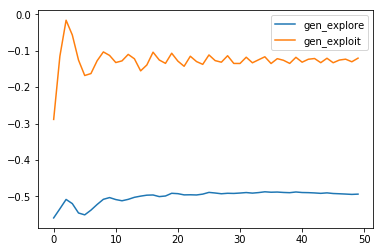

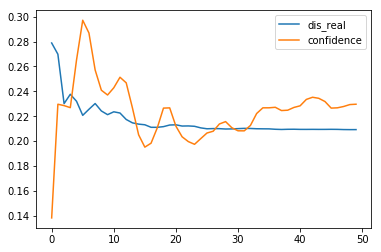

Generation 9  fitness : 31.0
#################################
Measured population fitness : 0s
population fitness : [19.  9. 10. 23. 10.  9.  8. 12.  9. 10.]
mean fit : 11.9
tensor([ 1.8129, -0.2709, -0.4793,  3.8967, -0.4793, -0.4793, -0.6876, -0.2709,
        -0.6876,  0.3542,  1.3961, -0.6876, -0.4793,  2.2297, -0.4793, -0.6876,
        -0.8960, -0.0625, -0.6876, -0.4793], device='cuda:0')
tensor([ 1.6036, -0.4884, -0.4974,  3.0733, -0.4987, -0.5890, -0.8103, -0.1796,
        -0.7171, -0.0594,  1.6036, -0.4884, -0.4974,  3.0733, -0.4987, -0.5890,
        -0.8103, -0.1796, -0.7171, -0.0594],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


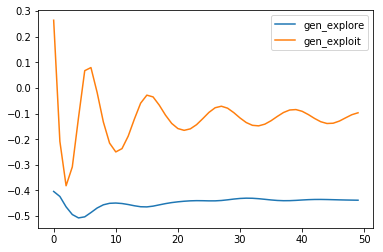

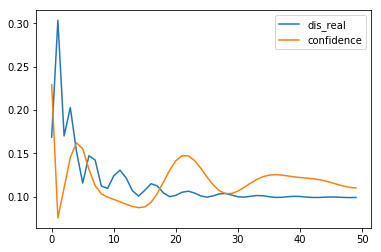

Generation 10  fitness : 23.0
#################################
Measured population fitness : 0s
population fitness : [24. 10. 11. 23.  9.  9. 10. 13. 10. 11.]
mean fit : 13.0
tensor([ 1.3662, -0.6925, -0.4866,  2.1897, -0.4866, -0.6925, -0.8983, -0.0749,
        -0.6925, -0.4866,  2.3956, -0.4866, -0.2807,  2.1897, -0.6925, -0.6925,
        -0.4866,  0.1310, -0.4866, -0.2807], device='cuda:0')
tensor([ 1.9265, -0.5860, -0.3787,  2.2113, -0.5977, -0.6943, -0.6855,  0.0493,
        -0.5814, -0.3774,  1.9265, -0.5860, -0.3787,  2.2113, -0.5977, -0.6943,
        -0.6855,  0.0493, -0.5814, -0.3774],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


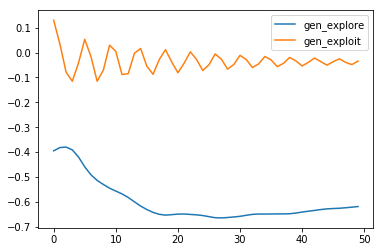

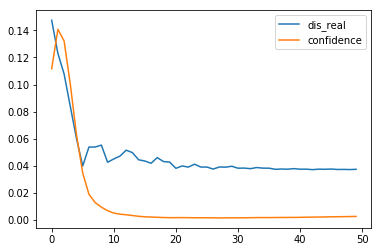

Generation 11  fitness : 24.0
#################################
Measured population fitness : 0s
population fitness : [21. 10. 10. 32.  9.  8.  8. 11.  9. 12.]
mean fit : 13.0
tensor([ 2.2683, -0.4733, -0.2774,  2.0725, -0.6691, -0.6691, -0.4733,  0.1142,
        -0.4733, -0.2774,  1.6809, -0.4733, -0.4733,  3.8350, -0.6691, -0.8649,
        -0.8649, -0.2774, -0.6691, -0.0816], device='cuda:0')
tensor([ 2.0005, -0.4999, -0.3636,  2.9926, -0.6733, -0.7756, -0.6629, -0.0827,
        -0.5686, -0.1684,  2.0005, -0.4999, -0.3636,  2.9926, -0.6733, -0.7756,
        -0.6629, -0.0827, -0.5686, -0.1684],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


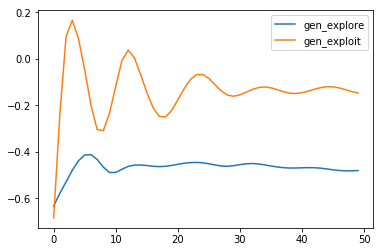

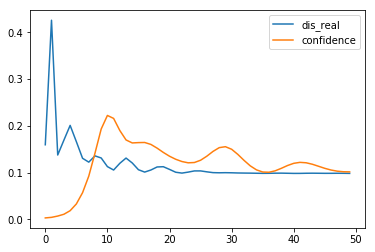

Generation 12  fitness : 32.0
#################################
Measured population fitness : 0s
population fitness : [23. 10.  8. 21. 11. 11.  9. 12. 10. 12.]
mean fit : 12.7
tensor([ 1.6835, -0.4795, -0.4795,  3.8466, -0.6761, -0.8728, -0.8728, -0.2829,
        -0.6761, -0.0862,  2.0768, -0.4795, -0.8728,  1.6835, -0.2829, -0.2829,
        -0.6761, -0.0862, -0.4795, -0.0862], device='cuda:0')
tensor([ 1.8940, -0.4796, -0.6773,  2.7678, -0.4666, -0.5667, -0.7777, -0.1795,
        -0.5712, -0.0741,  1.8940, -0.4796, -0.6773,  2.7678, -0.4666, -0.5667,
        -0.7777, -0.1795, -0.5712, -0.0741],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


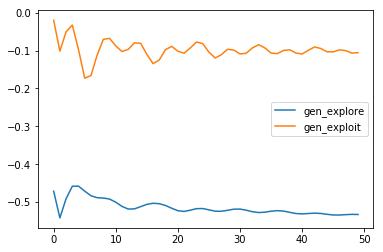

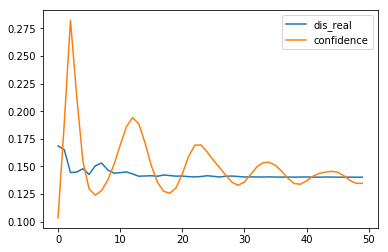

Generation 13  fitness : 23.0
#################################
Measured population fitness : 0s
population fitness : [25.  9. 10. 36. 11.  9.  9. 13.  9. 10.]
mean fit : 14.1
tensor([ 1.9216, -0.4705, -0.8386,  1.5536, -0.2865, -0.2865, -0.6546, -0.1025,
        -0.4705, -0.1025,  2.2897, -0.6546, -0.4705,  4.3138, -0.2865, -0.6546,
        -0.6546,  0.0815, -0.6546, -0.4705], device='cuda:0')
tensor([ 2.0750, -0.5523, -0.6367,  2.9013, -0.2715, -0.4611, -0.6471, -0.0111,
        -0.5566, -0.2760,  2.0750, -0.5523, -0.6367,  2.9013, -0.2715, -0.4611,
        -0.6471, -0.0111, -0.5566, -0.2760],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


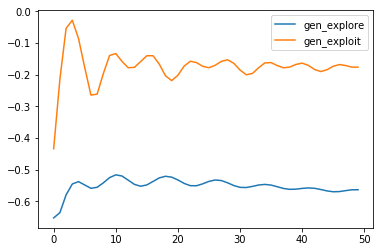

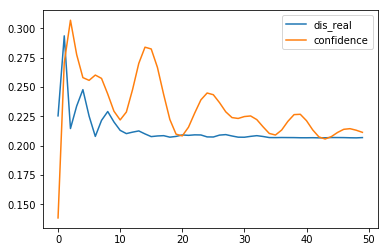

Generation 14  fitness : 36.0
#################################
Measured population fitness : 0s
population fitness : [25.  8. 11. 32. 10. 12. 10. 12.  9. 13.]
mean fit : 14.2
tensor([ 2.1997, -0.6540, -0.4756,  4.1617, -0.2973, -0.6540, -0.6540,  0.0595,
        -0.6540, -0.4756,  2.1997, -0.8323, -0.2973,  3.4482, -0.4756, -0.1189,
        -0.4756, -0.1189, -0.6540,  0.0595], device='cuda:0')
tensor([ 2.1931, -0.7468, -0.3781,  3.8007, -0.3747, -0.3723, -0.5698, -0.0319,
        -0.6456, -0.2105,  2.1931, -0.7468, -0.3781,  3.8007, -0.3747, -0.3723,
        -0.5698, -0.0319, -0.6456, -0.2105],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


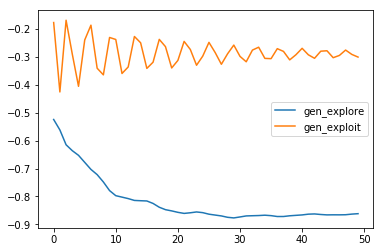

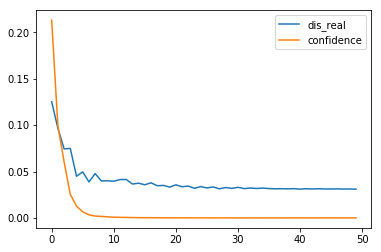

Generation 15  fitness : 32.0
#################################
Measured population fitness : 0s
population fitness : [18.  8.  8. 38. 11. 10. 11. 11.  9.  9.]
mean fit : 13.3
tensor([ 2.1023, -0.8048, -0.2918,  3.2994, -0.4628, -0.1208, -0.4628, -0.1208,
        -0.6338,  0.0502,  0.9053, -0.8048, -0.8048,  4.3255, -0.2918, -0.4628,
        -0.2918, -0.2918, -0.6338, -0.6338], device='cuda:0')
tensor([ 1.5350, -0.7966, -0.5322,  3.8465, -0.3800, -0.2832, -0.3807, -0.1884,
        -0.6310, -0.2896,  1.5350, -0.7966, -0.5322,  3.8465, -0.3800, -0.2832,
        -0.3807, -0.1884, -0.6310, -0.2896],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


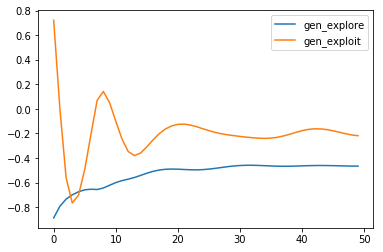

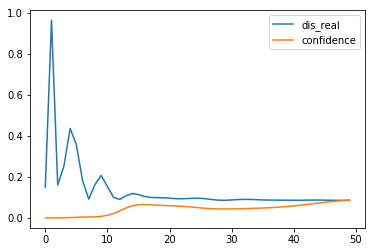

Generation 16  fitness : 38.0
#################################
Measured population fitness : 0s
population fitness : [26.  9.  9. 29.  9.  9. 10. 13.  9.  9.]
mean fit : 13.2
tensor([ 0.8860, -0.7969, -0.7969,  4.2516, -0.2920, -0.4603, -0.2920, -0.2920,
        -0.6286, -0.6286,  2.2322, -0.6286, -0.6286,  2.7371, -0.6286, -0.6286,
        -0.4603,  0.0445, -0.6286, -0.6286], device='cuda:0')
tensor([ 1.5666, -0.7205, -0.7079,  3.4979, -0.4646, -0.5390, -0.3712, -0.1178,
        -0.6323, -0.6288,  1.5666, -0.7205, -0.7079,  3.4979, -0.4646, -0.5390,
        -0.3712, -0.1178, -0.6323, -0.6288],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


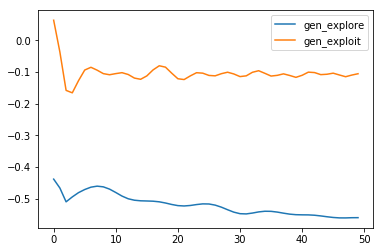

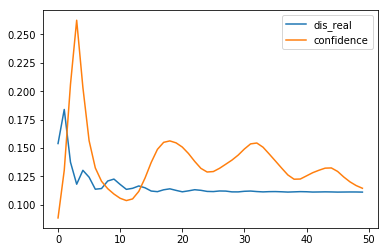

Generation 17  fitness : 29.0
#################################
Measured population fitness : 0s
population fitness : [18. 10. 10. 22. 10. 13.  9. 11. 10. 12.]
mean fit : 12.5
tensor([ 2.2690, -0.6361, -0.6361,  2.7816, -0.6361, -0.6361, -0.4652,  0.0475,
        -0.6361, -0.6361,  0.9019, -0.4652, -0.4652,  1.5854, -0.4652,  0.0475,
        -0.6361, -0.2943, -0.4652, -0.1234], device='cuda:0')
tensor([ 1.6104, -0.5608, -0.5509,  2.2271, -0.5696, -0.2991, -0.5496, -0.1143,
        -0.5556, -0.3781,  1.6104, -0.5608, -0.5509,  2.2271, -0.5696, -0.2991,
        -0.5496, -0.1143, -0.5556, -0.3781],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


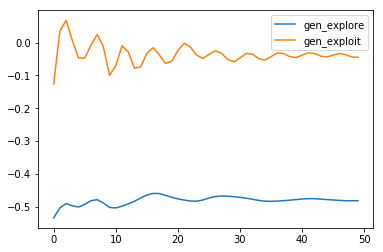

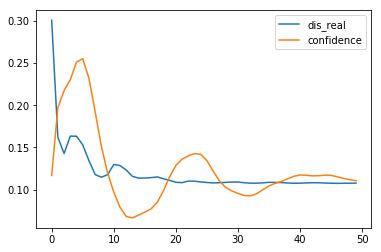

Generation 18  fitness : 22.0
#################################
Measured population fitness : 0s
population fitness : [23.  9. 10. 26.  9.  9.  8. 11.  9. 14.]
mean fit : 12.8
tensor([ 0.8992, -0.4648, -0.4648,  1.5812, -0.4648,  0.0467, -0.6353, -0.2943,
        -0.4648, -0.1238,  1.7517, -0.6353, -0.4648,  2.2632, -0.6353, -0.6353,
        -0.8058, -0.2943, -0.6353,  0.2172], device='cuda:0')
tensor([ 1.3576, -0.5627, -0.4691,  1.9531, -0.5576, -0.2963, -0.7313, -0.2975,
        -0.5698,  0.0308,  1.3576, -0.5627, -0.4691,  1.9531, -0.5576, -0.2963,
        -0.7313, -0.2975, -0.5698,  0.0308],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


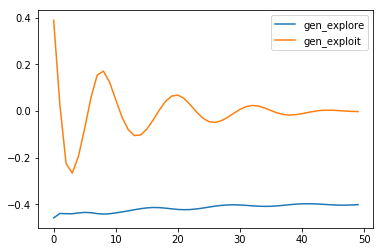

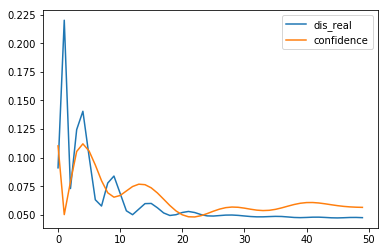

Generation 19  fitness : 26.0
#################################
Measured population fitness : 0s
population fitness : [18.  9.  9. 23.  8. 10.  9. 14. 10.  9.]
mean fit : 11.9
tensor([ 1.7738, -0.6337, -0.4617,  2.2897, -0.6337, -0.6337, -0.8057, -0.2898,
        -0.6337,  0.2261,  0.9140, -0.6337, -0.6337,  1.7738, -0.8057, -0.4617,
        -0.6337,  0.2261, -0.4617, -0.6337], device='cuda:0')
tensor([ 1.3436, -0.6389, -0.5593,  2.0260, -0.7323, -0.5646, -0.7267, -0.0281,
        -0.5520, -0.2097,  1.3436, -0.6389, -0.5593,  2.0260, -0.7323, -0.5646,
        -0.7267, -0.0281, -0.5520, -0.2097],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


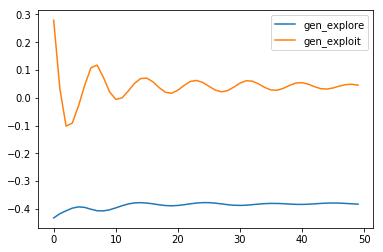

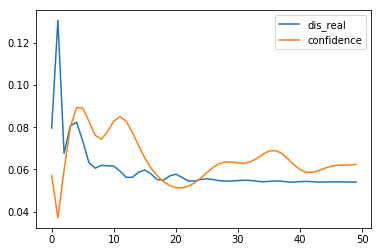

Generation 20  fitness : 23.0
#################################
Measured population fitness : 0s
population fitness : [28.  9.  9. 32. 11. 11.  9. 12. 10. 10.]
mean fit : 14.1
tensor([ 0.8822, -0.6308, -0.6308,  1.7227, -0.7989, -0.4627, -0.6308,  0.2097,
        -0.4627, -0.6308,  2.5632, -0.6308, -0.6308,  3.2356, -0.2946, -0.2946,
        -0.6308, -0.1265, -0.4627, -0.4627], device='cuda:0')
tensor([ 1.7295, -0.6174, -0.6266,  2.4766, -0.5402, -0.3759, -0.6214,  0.0514,
        -0.4489, -0.5503,  1.7295, -0.6174, -0.6266,  2.4766, -0.5402, -0.3759,
        -0.6214,  0.0514, -0.4489, -0.5503],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


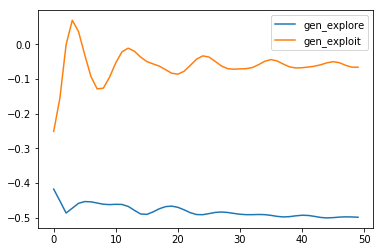

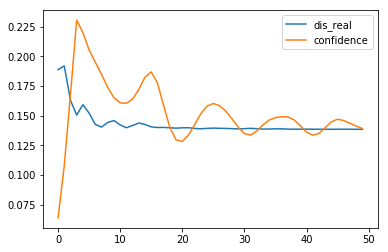

Generation 21  fitness : 32.0
#################################
Measured population fitness : 0s
population fitness : [18.  9.  9. 30. 10. 14.  9. 12. 10. 11.]
mean fit : 13.2
tensor([ 2.5543, -0.6329, -0.6329,  3.2253, -0.2974, -0.2974, -0.6329, -0.1296,
        -0.4651, -0.4651,  0.8768, -0.6329, -0.6329,  2.8898, -0.4651,  0.2059,
        -0.6329, -0.1296, -0.4651, -0.2974], device='cuda:0')
tensor([ 1.7002, -0.6263, -0.6309,  3.0500, -0.3764, -0.0334, -0.6293, -0.1311,
        -0.4605, -0.3745,  1.7002, -0.6263, -0.6309,  3.0500, -0.3764, -0.0334,
        -0.6293, -0.1311, -0.4605, -0.3745],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


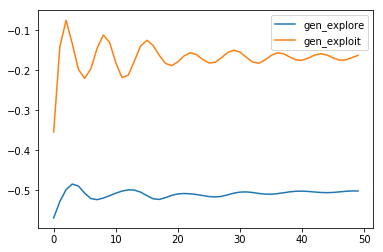

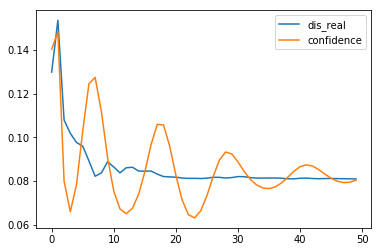

Generation 22  fitness : 30.0
#################################
Measured population fitness : 0s
population fitness : [22. 10. 10. 24. 11. 12.  9. 11. 10.  9.]
mean fit : 12.8
tensor([ 0.8813, -0.6364, -0.6364,  2.9048, -0.4678,  0.2068, -0.6364, -0.1305,
        -0.4678, -0.2991,  1.5558, -0.4678, -0.4678,  1.8931, -0.2991, -0.1305,
        -0.6364, -0.2991, -0.4678, -0.6364], device='cuda:0')
tensor([ 1.2380, -0.5519, -0.5552,  2.4505, -0.3800,  0.0428, -0.6359, -0.2173,
        -0.4653, -0.4742,  1.2380, -0.5519, -0.5552,  2.4505, -0.3800,  0.0428,
        -0.6359, -0.2173, -0.4653, -0.4742],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


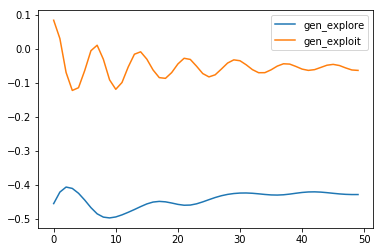

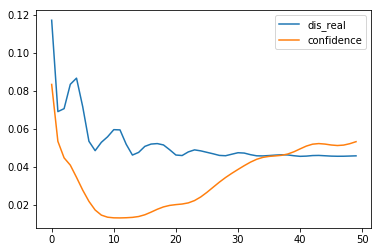

Generation 23  fitness : 24.0
#################################
Measured population fitness : 0s
population fitness : [16.  9.  9. 24. 11. 15.  9. 13. 10. 10.]
mean fit : 12.6


KeyboardInterrupt: 

In [3]:
population = []
max_population_batch = 2
n_generations = 300
population_size = 10

for p in range(population_size):
    creat = Creature(env.observation_space.shape[0],creature_out_size).to(device)
    #pars = torch.from_numpy(np.random.uniform(0,1,get_params(creat).numel())).type('torch.FloatTensor').to(device)
    pars = torch.tanh(get_params(creat))
    creat = set_params(creat,pars)
    population.append(creat)
    
print("starting training")
creature_size = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
print(creature_size)

old_population = []
old_fitnesses = []
all_fitnesses = []

gen = Generator(creature_size,device).to(device)
dis = Discriminator().to(device)


for i in range(n_generations):
    start_time = time.time()
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.001,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.001,betas=(0.9,0.999))
    
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    print("Measured population fitness : {}s".format(int(time.time() - start_time)))
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    all_fitnesses.append(p_fitness_)
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))   
    
    #define population batch
    population_concat = np.concatenate(np.array(old_population))
    population_batch = []
    for p in population_concat:
        #print(get_params(p))
        population_batch.append(get_params(p))
    population_batch = torch.stack(population_batch, dim=0).to(device)
    
    #define fitness batch
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    fitness_batch_normed = ((fitness_batch - np.mean(all_fitnesses))/np.std(all_fitnesses))
    
    #Train GAN
    start_time = time.time()
    n_epochs = 50
    if i == 0:
        n_epochs = 150
        
    gen_explore_all,gen_exploit_all, dis_loss ,dis_confidence_all= train_gan(population_batch
                                                                                       ,fitness_batch_normed,
              fitness_batch.size,batch_size =fitness_batch.size,n_epochs = n_epochs)
    
    print("Trained GAN : {}s".format(int(time.time() - start_time)))
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
        
    
    #print(population_batch[population_batch.size(0)  - population_size:].shape,population_batch.shape)
    mutations = gen(population_batch[population_batch.size(0)  - population_size:],lr)
    #Apply mutations
    
    for idx,p in enumerate(population_batch[population_batch.size(0) - population_size:]):
        child = Creature(env.observation_space.shape[0],creature_out_size) 
        population[idx] = set_params(child,p + mutations[idx])
    
    
    plt.plot(gen_explore_all,label='gen_explore')
    plt.plot(gen_exploit_all,label='gen_exploit')
    plt.legend()
    plt.show()
    plt.plot(dis_loss,label='dis_real')
    plt.plot(dis_confidence_all,label='confidence')
    #plt.ylim(0,5)
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")